# Content personalization

🏗️ work in progress.

## Without context

This example takes inspiration from Vowpal Wabbit's [excellent tutorial](https://vowpalwabbit.org/tutorials/cb_simulation.html).

Content personalization is about taking into account user preferences. It's a special case of recommender systems. Ideally, side-information should be taken into account in addition to the user. But we'll start with something simpler, where we only take into account the user and their preferences for each item.

In [132]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ['politics', 'sports', 'music', 'food', 'finance', 'health', 'camping']

def get_reward(user, item, context):

    time_of_day = context['time_of_day']

    USER_LIKED_ARTICLE = 1
    USER_DISLIKED_ARTICLE = 0

    if user == 'Tom':
        if time_of_day == 'morning' and item == 'politics':
            return USER_LIKED_ARTICLE
        elif time_of_day == 'afternoon' and item == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif user == 'Anna':
        if time_of_day == 'morning' and item == 'sports':
            return USER_LIKED_ARTICLE
        elif time_of_day == 'afternoon' and item == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

get_reward('Tom', 'politics', {'time_of_day': 'morning'})

1

This is a toy problem, and so it's possible to print out all the outcomes.

In [191]:
import itertools

def print_preferences(reward_func, users=users, times_of_day=times_of_day, actions=actions):
    print(f'{"User":<5} {"Time of day":<12}' + ' '.join(f'{action:>9}' for action in actions))
    for user, time_of_day in itertools.product(users, times_of_day):
        rewards = [reward_func(user, action, {'time_of_day': time_of_day}) for action in actions]
        print(f'{user:>5} {time_of_day:>12}' + ' '.join(f'{reward:>9.1f}' for reward in rewards))

print_preferences(get_reward)

User  Time of day  politics    sports     music      food   finance    health   camping
  Tom      morning      1.0       0.0       0.0       0.0       0.0       0.0       0.0
  Tom    afternoon      0.0       0.0       1.0       0.0       0.0       0.0       0.0
 Anna      morning      0.0       1.0       0.0       0.0       0.0       0.0       0.0
 Anna    afternoon      1.0       0.0       0.0       0.0       0.0       0.0       0.0


Measuring the performance of a recommender system is not straightforward, mostly because of the interactive aspect. In a real situation, recommendations are presented to a user, and the user gives feedback indicating whether they like what they have been recommended or not. This feedback loop can't be captured entirely by a historical dataset. Some kind of simulator is required to generate recommendations and capture feedback. We already have a reward function. Now let's implement a simulation function.

In [291]:
import random
import matplotlib.pyplot as plt

def plot_ctr(ctr):
    plt.plot(range(1, len(ctr) + 1), ctr)
    plt.xlabel('n_iterations', fontsize=14)
    plt.ylabel('CTR', fontsize=14)
    plt.ylim([0, 1])
    plt.title(f'final CTR: {ctr[-1]:.2%}', fontsize=14)
    plt.grid()

def simulate(n, reward_func, model, seed, users=users, items=actions, times_of_day=times_of_day):
    
    rng = random.Random(seed)
    n_clicks = 0
    ctr = []  # click-through rate along time
    
    for i in range(n):
        
        # Generate a context at random
        user = rng.choice(users)
        context = {'time_of_day': rng.choice(times_of_day)}
    
        # Make a single recommendation
        item = model.sample(user, items=items, x=context)
        
        # Measure the reward
        clicked = reward_func(user, item, context)
        n_clicks += clicked
        ctr.append(n_clicks / (i + 1))
        
        # Update the model
        model.learn_one(user, item, y=clicked, x=context)
        
    plot_ctr(ctr)

This simulation function does quite a few things. It can be seen as a simple reinforcement learning simulation. It samples a user, and then asks the model to provide a single recommendation. The user then gives feedback as to whether they liked the recommendation or not. Crucially, the user doesn't tell us what item they would have liked. We could model this as a multi-class classification problem if that were the case.

We can first evaluate a recommended which acts completely at random. It assigns a random preference to each item, regardless of the user.

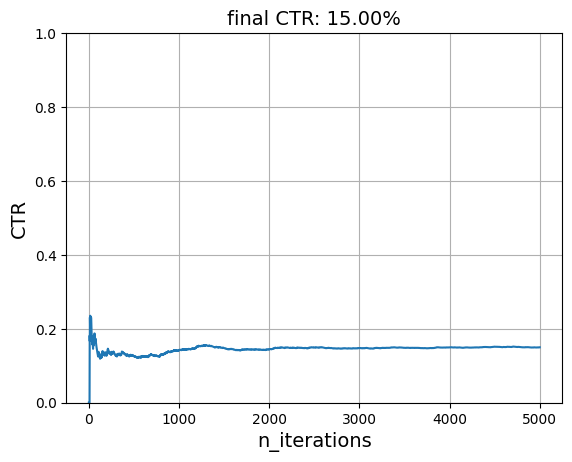

In [257]:
from river import reco

model = reco.RandomNormal(seed=42)
simulate(5_000, get_reward, model, seed=42)

We can see that the click-through rate (CTR) oscillates around 14%. This is because each context has a single action that yields a like. There are seven possible actions, so the expected performance of a random strategy is $\frac{1}{7} = 14.29\%$.

A good model should at the very least understand what kind of items each user prefers. One of the simplest and yet performant way to do this is Simon Funk's SGD method he developped for the Netflix challenge and wrote about [here](https://sifter.org/simon/journal/20061211.html). It models each user and each item as latent vectors. The dot product of these two vectors is the expected preference of the user for the item.

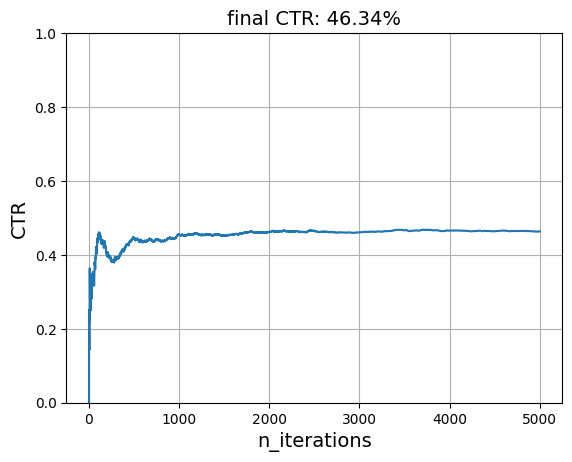

In [447]:
model = reco.FunkMF(seed=10)
simulate(5_000, get_reward, model, seed=42)

In [448]:
print_preferences(model.predict_one)

User  Time of day  politics    sports     music      food   finance    health   camping
  Tom      morning      0.5      -0.1       0.6      -0.0      -0.0      -0.1      -0.0
  Tom    afternoon      0.5      -0.1       0.6      -0.0      -0.0      -0.1      -0.0
 Anna      morning      0.4      -0.2       0.1       0.0      -0.0      -0.1       0.0
 Anna    afternoon      0.4      -0.2       0.1       0.0      -0.0      -0.1       0.0


This model is doing better than random. However, when we take a look at the obtained preference scores, we can see that the model isn't able to distinguish between the two times of the day. That's expected because the model is not contextual. This explains why the model performs well roughly half of the time, and poorly the other half.

We can force the simulation to only pick one time of the day. This is cheating, but it allows us to see how the model performs when it's not confused by the context.

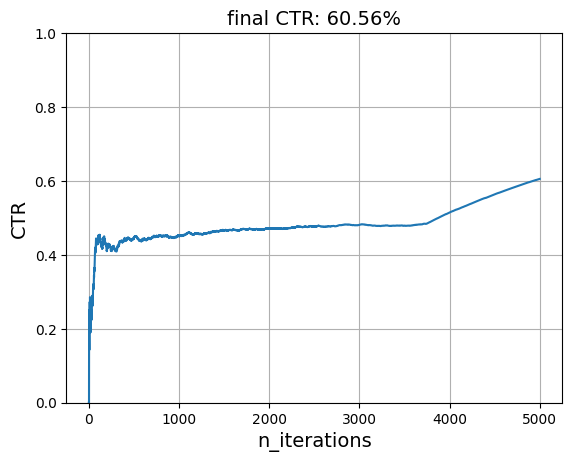

In [478]:
model = reco.FunkMF(seed=10)
simulate(5_000, get_reward, model, seed=42, times_of_day=['morning'])

In [457]:
print_preferences(model.predict_one, times_of_day=['morning'])

User  Time of day  politics    sports     music      food   finance    health   camping
  Tom      morning      1.0      -0.2       0.0       0.0       0.0      -0.2       0.0
 Anna      morning     -0.2       1.0      -0.0      -0.0       0.0      -0.0       0.0


We can see that this model learns what items each user enjoys quite well. The performance does not reach 100% because there is still some exploration involved.

All of this is of course more complex in reality. Users will get fed up with recommendations if they're always shown the same item. It's important to include diversity into recommendations, and to let the model explore other options instead of always focusing on the item with the highest score. This is where evaluating recommender systems gets tricky: the reward function itself is difficult to model.

We will keep ignoring these caveats in this notebook. Instead we will focus on a different concern: making recommendations when context is involved.

## With context

Let's now try to handle the context, by making it so that user preferences change depending on the time the day. In our toy problem, user preferences change between morning and afternoon.

Before delving into recsys models that can handle context, a simple hack is to append the time of day to the user's name. This effectively results in new users which our model can distinguish between. We could apply this trick during the simulation, but we can also override the behavior of the `predict_one` and `learn_one` and methods.

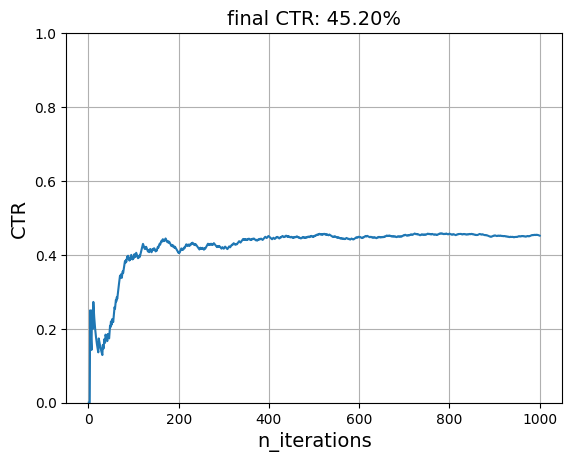

In [522]:
class FunkMFWithHack(reco.FunkMF):

    def predict_one(self, user, items, x=None):
        user = f"{user}@{x['time_of_day']}"
        return super().predict_one(user, items)

    def learn_one(self, user, item, y, x):
        user = f"{user}@{x['time_of_day']}"
        return super().learn_one(user, item, y, x)

model = FunkMFWithHack(seed=10)
simulate(1_000, get_reward, model, seed=42)

In [523]:
print_preferences(model.predict_one)

User  Time of day  politics    sports     music      food   finance    health   camping
  Tom      morning      9.0      -0.4      -1.4       0.0       0.1      -0.5       0.4
  Tom    afternoon     -1.4       0.5     299.5       0.4       4.9       0.6      -3.8
 Anna      morning      0.2      -0.2    -108.0      -0.2      -1.8      -0.1       1.4
 Anna    afternoon     -0.3      -0.0      -0.8       0.0      -0.0       0.1      -0.0
